# Pandas: Groupby

`groupby` is an amazingly powerful function in pandas. But it is also complicated to use and understand.
The point of this notebook is to make you feel confident in using `groupby` and its cousins, `resample` and `rolling`. 

These notes are loosely based on the [Pandas GroupBy Documentation](http://pandas.pydata.org/pandas-docs/stable/groupby.html).


:::{seealso}
The "split/apply/combine" concept was first introduced in a paper by Hadley Wickham: <https://www.jstatsoft.org/article/view/v040i01>.
:::

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
# %config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (12,7)
plt.ion()  # To trigger the interactive inline mode

Use the following code to load a CSV file of the [NOAA IBTrACS cyclones](https://www.ncdc.noaa.gov/ibtracs/index.php?name=ibtracs-data) dataset:

In [65]:
#url = 'https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/csv/ibtracs.ALL.list.v04r00.csv'
url = 'ibtracs.last3years.list.v04r00.csv'
df = pd.read_csv(url, parse_dates=['ISO_TIME'], usecols=range(12), index_col='SID',
                 skiprows=[1], na_values=[' ', 'NOT_NAMED'],
                 keep_default_na=False, dtype={'NAME': str})
df.head()

,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,WMO_WIND,WMO_PRES
SID,,,,,,,,,,,
2018004S08095,2018,1,SI,WA,IRVING,2018-01-03 18:00:00,NR,-8.27000,95.3300,25.0,1004.0
2018004S08095,2018,1,SI,WA,IRVING,2018-01-03 21:00:00,NR,-8.36815,95.7494,NaN,NaN
2018004S08095,2018,1,SI,WA,IRVING,2018-01-04 00:00:00,NR,-8.60000,96.0000,25.0,1004.0
2018004S08095,2018,1,SI,WA,IRVING,2018-01-04 03:00:00,NR,-9.03721,95.9729,NaN,NaN
2018004S08095,2018,1,SI,WA,IRVING,2018-01-04 06:00:00,NR,-9.50000,95.8000,25.0,1004.0


**Basin Key:** 
+ NA - North Atlantic
+ EP - Eastern North Pacific 
+ WP - Western North Pacific 
+ NI - North Indian
+ SI - South Indian
+ SP - Southern Pacific
+ SA - South Atlantic

## An Example

This is an example of a "one-liner" that you can accomplish with groupby.

<AxesSubplot:xlabel='BASIN'>

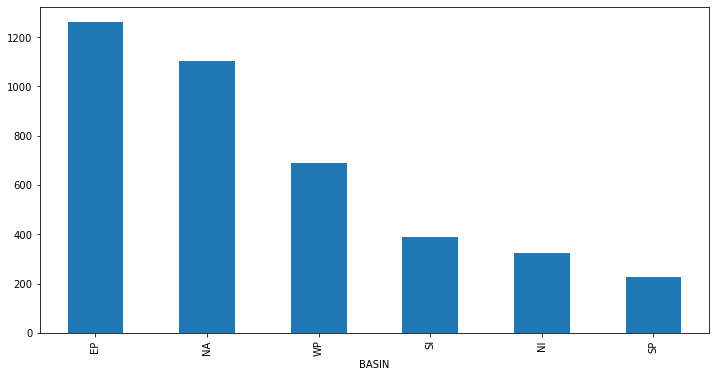

In [66]:
df.groupby('BASIN').WMO_WIND.count().nlargest(20).plot(kind='bar', figsize=(12,6))

## What Happened?

Let's break apart this operation a bit. The workflow with `groubpy` can be divided into three general steps:

1. **Split**: Partition the data into different groups based on some criterion.
1. **Apply**: Do some caclulation within each group. Different types of "apply" steps might be
  1. *Aggregation*: Get the mean or max within the group.
  1. *Transformation*: Normalize all the values within a group
  1. *Filtration*: Eliminate some groups based on a criterion.
1. **Combine**: Put the results back together into a single object.

![split-apply-combine](https://miro.medium.com/max/1840/1*JbF6nhrQsn4f-TaSF6IR9g.png)

### The `groupby` method

Both `Series` and `DataFrame` objects have a groupby method. It accepts a variety of arguments, but the simplest way to think about it is that you pass another series, whose unique values are used to split the original object into different groups.

In [67]:
df.groupby(df.BASIN)

There is a shortcut for doing this with dataframes: you just pass the column name:

In [68]:
df.groupby('BASIN')

### The `GroubBy` object

When we call, `groupby` we get back a `GroupBy` object:

In [69]:
gb = df.groupby('BASIN')
gb

The length tells us how many groups were found:

In [70]:
len(gb)

6

All of the groups are available as a dictionary via the `.groups` attribute:

In [71]:
groups = gb.groups
len(groups)

6

In [72]:
list(groups.keys())

['EP', 'NA', 'NI', 'SI', 'SP', 'WP']

### Iterating and selecting groups

You can loop through the groups if you want.

In [73]:
for key, group in gb:
    display(group.head())
    print(f'The key is "{key}"')
    break

,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,WMO_WIND,WMO_PRES
SID,,,,,,,,,,,
2018131N12235,2018,23,EP,MM,NaN,2018-05-10 12:00:00,TS,12.1000,-125.400,25.0,1008.0
2018131N12235,2018,23,EP,MM,NaN,2018-05-10 15:00:00,TS,12.2101,-125.790,NaN,NaN
2018131N12235,2018,23,EP,MM,NaN,2018-05-10 18:00:00,TS,12.3000,-126.200,30.0,1007.0
2018131N12235,2018,23,EP,MM,NaN,2018-05-10 21:00:00,TS,12.3575,-126.643,NaN,NaN
2018131N12235,2018,23,EP,MM,NaN,2018-05-11 00:00:00,TS,12.4000,-127.100,30.0,1007.0


The key is "EP"


And you can get a specific group by key.

In [74]:
gb.get_group('SP').head()

,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,WMO_WIND,WMO_PRES
SID,,,,,,,,,,,
2018027S11156,2018,5,SP,EA,FEHI,2018-01-26 12:00:00,DS,-11.4000,156.100,NaN,NaN
2018027S11156,2018,5,SP,EA,FEHI,2018-01-26 15:00:00,DS,-11.5675,156.525,NaN,NaN
2018027S11156,2018,5,SP,EA,FEHI,2018-01-26 18:00:00,DS,-11.8000,157.000,NaN,NaN
2018027S11156,2018,5,SP,EA,FEHI,2018-01-26 21:00:00,DS,-12.1477,157.537,NaN,NaN
2018027S11156,2018,5,SP,EA,FEHI,2018-01-27 00:00:00,TS,-12.6000,158.000,NaN,NaN


## Aggregation

Now that we know how to create a `GroupBy` object, let's learn how to do aggregation on it.

One way us to use the `.aggregate` method, which accepts another function as its argument. The result is automatically combined into a new dataframe with the group key as the index.

We can use both `.` or `[]` syntax to select a specific column to operate on. Then we get back a series.

In [75]:
gb.WMO_WIND.aggregate(np.max).head()

BASIN
EP    140.0
NA    160.0
NI     95.0
SI    125.0
SP    110.0
Name: WMO_WIND, dtype: float64

In [76]:
gb.WMO_WIND.aggregate(np.max).nlargest(10)

BASIN
NA    160.0
EP    140.0
SI    125.0
WP    115.0
SP    110.0
NI     95.0
Name: WMO_WIND, dtype: float64

There are shortcuts for common aggregation functions:

In [77]:
gb.WMO_WIND.max().nlargest(10)

BASIN
NA    160.0
EP    140.0
SI    125.0
WP    115.0
SP    110.0
NI     95.0
Name: WMO_WIND, dtype: float64

In [78]:
gb.WMO_WIND.min().nsmallest(10)

BASIN
SI    10.0
EP    15.0
NA    15.0
SP    15.0
NI    20.0
WP    35.0
Name: WMO_WIND, dtype: float64

In [79]:
gb.WMO_WIND.mean().nlargest(10)

BASIN
WP    61.534009
EP    51.912698
NA    50.308810
SP    47.766520
SI    46.231362
NI    41.353846
Name: WMO_WIND, dtype: float64

In [80]:
gb.WMO_WIND.std().nlargest(10)

BASIN
EP    30.176084
NA    24.634510
SP    23.220435
WP    22.915217
SI    22.771114
NI    17.673680
Name: WMO_WIND, dtype: float64

We can also apply multiple functions at once:

In [81]:
gb.WMO_WIND.aggregate([np.min, np.max, np.mean]).head()

,amin,amax,mean
BASIN,,,
EP,15.0,140.0,51.912698
NA,15.0,160.0,50.308810
NI,20.0,95.0,41.353846
SI,10.0,125.0,46.231362
SP,15.0,110.0,47.766520


<AxesSubplot:xlabel='BASIN'>

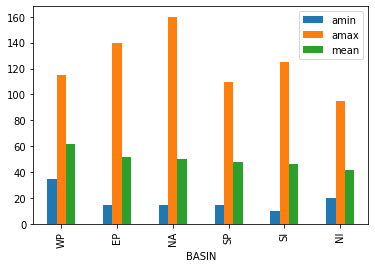

In [82]:
gb.WMO_WIND.aggregate([np.min, np.max, np.mean]).nlargest(10, 'mean').plot(kind='bar')

## Transformation

The key difference between aggregation and transformation is that aggregation returns a *smaller* object than the original, indexed by the group keys, while *transformation* returns an object with the same index (and same size) as the original object. Groupby + transformation is used when applying an operation that requires information about the whole group.

In this example, we standardize the earthquakes in each country so that the distribution has zero mean and unit variance. We do this by first defining a function called `standardize` and then passing it to the `transform` method.

I admit that I don't know why you would want to do this. `transform` makes more sense to me in the context of time grouping operation. See below for another example.

In [84]:
def standardize(x):
    return (x - x.mean())/x.std()

wind_standardized_by_basin = gb.WMO_WIND.transform(standardize)
wind_standardized_by_basin

SID
2018004S08095   -0.932381
2018004S08095         NaN
2018004S08095   -0.932381
2018004S08095         NaN
2018004S08095   -0.932381
                   ...   
2021067S24058         NaN
2021067S24058         NaN
2021067S24058         NaN
2021067S24058         NaN
2021067S24058         NaN
Name: WMO_WIND, Length: 17783, dtype: float64

## Time Grouping

We already saw how pandas has a strong built-in understanding of time. This capability is even more powerful in the context of `groupby`. With datasets indexed by a pandas `DateTimeIndex`, we can easily group and resample the data using common time units.

To get started, let's load a NOAA timeseries data:

In [85]:
import urllib

header_url = 'ftp://ftp.ncdc.noaa.gov/pub/data/uscrn/products/daily01/HEADERS.txt'
with urllib.request.urlopen(header_url) as response:
    data = response.read().decode('utf-8')
lines = data.split('\n')
headers = lines[1].split(' ')

ftp_base = 'ftp://ftp.ncdc.noaa.gov/pub/data/uscrn/products/daily01/'
dframes = []
for year in range(2016, 2019):
    data_url = f'{year}/CRND0103-{year}-NY_Millbrook_3_W.txt'               
    df = pd.read_csv(ftp_base + data_url, parse_dates=[1],
                     names=headers, header=None, sep='\s+',
                     na_values=[-9999.0, -99.0])
    dframes.append(df)

df = pd.concat(dframes)
df = df.set_index('LST_DATE')

In [54]:
df.head()

,WBANNO,CRX_VN,LONGITUDE,LATITUDE,T_DAILY_MAX,T_DAILY_MIN,T_DAILY_MEAN,T_DAILY_AVG,P_DAILY_CALC,SOLARAD_DAILY,...,SOIL_MOISTURE_10_DAILY,SOIL_MOISTURE_20_DAILY,SOIL_MOISTURE_50_DAILY,SOIL_MOISTURE_100_DAILY,SOIL_TEMP_5_DAILY,SOIL_TEMP_10_DAILY,SOIL_TEMP_20_DAILY,SOIL_TEMP_50_DAILY,SOIL_TEMP_100_DAILY,
LST_DATE,,,,,,,,,,,,,,,,,,,,,
2016-01-01,64756,2.422,-73.74,41.79,3.4,-0.5,1.5,1.3,0.0,1.69,...,0.233,0.204,0.155,0.147,4.2,4.4,5.1,6.0,7.6,NaN
2016-01-02,64756,2.422,-73.74,41.79,2.9,-3.6,-0.4,-0.3,0.0,6.25,...,0.227,0.199,0.152,0.144,2.8,3.1,4.2,5.7,7.4,NaN
2016-01-03,64756,2.422,-73.74,41.79,5.1,-1.8,1.6,1.1,0.0,5.69,...,0.223,0.196,0.151,0.141,2.6,2.8,3.8,5.2,7.2,NaN
2016-01-04,64756,2.422,-73.74,41.79,0.5,-14.4,-6.9,-7.5,0.0,9.17,...,0.220,0.194,0.148,0.139,1.7,2.1,3.4,4.9,6.9,NaN
2016-01-05,64756,2.422,-73.74,41.79,-5.2,-15.5,-10.3,-11.7,0.0,9.34,...,0.213,0.191,0.148,0.138,0.4,0.9,2.4,4.3,6.6,NaN


This timeseries has daily resolution, and the daily plots are somewhat noisy.

<AxesSubplot:xlabel='LST_DATE'>

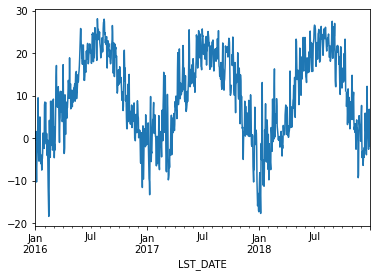

In [55]:
df.T_DAILY_MEAN.plot()

A common way to analyze such data in climate science is to create a "climatology," which contains the average values in each month or day of the year. We can do this easily with groupby. Recall that `df.index` is a pandas `DateTimeIndex` object.

In [56]:
monthly_climatology = df.groupby(df.index.month).mean()
monthly_climatology

,WBANNO,CRX_VN,LONGITUDE,LATITUDE,T_DAILY_MAX,T_DAILY_MIN,T_DAILY_MEAN,T_DAILY_AVG,P_DAILY_CALC,SOLARAD_DAILY,...,SOIL_MOISTURE_10_DAILY,SOIL_MOISTURE_20_DAILY,SOIL_MOISTURE_50_DAILY,SOIL_MOISTURE_100_DAILY,SOIL_TEMP_5_DAILY,SOIL_TEMP_10_DAILY,SOIL_TEMP_20_DAILY,SOIL_TEMP_50_DAILY,SOIL_TEMP_100_DAILY,
LST_DATE,,,,,,,,,,,,,,,,,,,,,
1,64756,2.488667,-73.74,41.79,2.924731,-7.122581,-2.100000,-1.905376,2.478495,5.812258,...,0.240250,0.199528,0.150387,0.162554,0.168817,0.232258,0.788172,1.749462,3.395699,NaN
2,64756,2.487882,-73.74,41.79,6.431765,-5.015294,0.712941,1.022353,4.077647,8.495882,...,0.244229,0.203089,0.154294,0.165494,1.217647,1.183529,1.281176,1.602353,2.460000,NaN
3,64756,2.488667,-73.74,41.79,7.953763,-3.035484,2.455914,2.643011,2.788172,13.211290,...,0.224155,0.190753,0.153108,0.161742,3.469892,3.407527,3.379570,3.473118,3.792473,NaN
4,64756,2.488667,-73.74,41.79,14.793333,1.816667,8.302222,8.574444,2.396667,15.295889,...,0.208611,0.183922,0.150022,0.159956,9.402222,9.140000,8.438889,7.600000,6.633333,NaN
5,64756,2.488667,-73.74,41.79,21.235484,8.460215,14.850538,15.121505,3.015054,17.288602,...,0.198925,0.175441,0.146011,0.157710,16.889247,16.693548,15.570968,14.193548,12.344086,NaN
6,64756,2.488667,-73.74,41.79,25.627778,11.837778,18.733333,19.026667,3.053333,21.913333,...,0.132867,0.127067,0.128344,0.154989,22.372222,22.198889,20.917778,19.421111,17.453333,NaN
7,64756,2.488667,-73.74,41.79,28.568817,15.536559,22.054839,22.012903,3.865591,21.570645,...,0.100871,0.084978,0.112516,0.153264,25.453763,25.408602,24.141935,22.725806,20.994624,NaN
8,64756,2.488667,-73.74,41.79,27.473118,15.351613,21.410753,21.378495,4.480645,18.493333,...,0.150914,0.121323,0.125398,0.162667,24.784946,24.897849,24.117204,23.311828,22.278495,NaN
9,64756,2.488667,-73.74,41.79,24.084444,12.032222,18.057778,17.866667,3.730000,13.625667,...,0.131133,0.113678,0.117722,0.157660,21.061111,21.220000,20.947778,20.823333,20.717778,NaN


Each row in this new dataframe respresents the average values for the months (1=January, 2=February, etc.)

We can apply more customized aggregations, as with any groupby operation. Below we keep the mean of the mean, max of the max, and min of the min for the temperature measurements.

In [57]:
monthly_T_climatology = df.groupby(df.index.month).aggregate({'T_DAILY_MEAN': 'mean',
                                                              'T_DAILY_MAX': 'max',
                                                              'T_DAILY_MIN': 'min'})
monthly_T_climatology.head()

,T_DAILY_MEAN,T_DAILY_MAX,T_DAILY_MIN
LST_DATE,,,
1,-2.100000,16.9,-26.0
2,0.712941,24.9,-24.7
3,2.455914,26.8,-16.5
4,8.302222,30.6,-11.3
5,14.850538,33.4,-1.6


<AxesSubplot:xlabel='LST_DATE'>

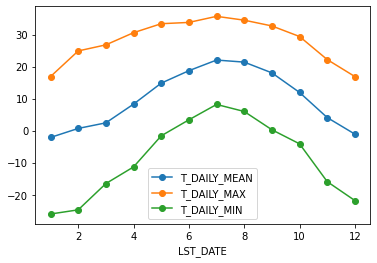

In [58]:
monthly_T_climatology.plot(marker='o')

If we want to do it on a finer scale, we can group by day of year.

<AxesSubplot:xlabel='LST_DATE'>

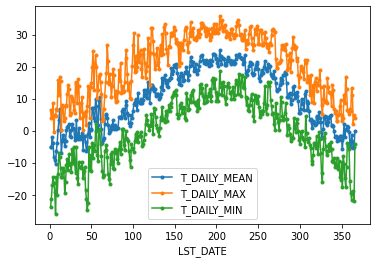

In [59]:
daily_T_climatology = df.groupby(df.index.dayofyear).aggregate({'T_DAILY_MEAN': 'mean',
                                                            'T_DAILY_MAX': 'max',
                                                            'T_DAILY_MIN': 'min'})
daily_T_climatology.plot(marker='.')

### Calculating anomalies

A common mode of analysis in climate science is to remove the climatology from a signal to focus only on the "anomaly" values. This can be accomplished with transformation.

<AxesSubplot:xlabel='LST_DATE'>

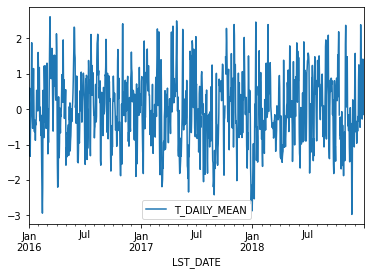

In [60]:
def standardize(x):
    return (x - x.mean())/x.std()

anomaly = df.groupby(df.index.month).transform(standardize)
anomaly.plot(y='T_DAILY_MEAN')

### Resampling

Another common operation is to change the resolution of a dataset by resampling in time. Pandas exposes this through the [resample](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#resampling) function. The resample periods are specified using pandas [offset index](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases) syntax.

Below we resample the dataset by taking the mean over each month.

<AxesSubplot:xlabel='LST_DATE'>

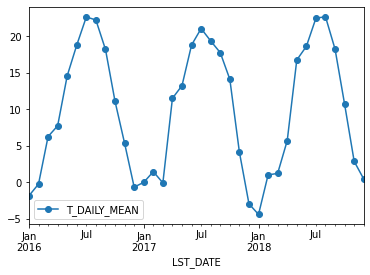

In [61]:
df.resample('M').mean().plot(y='T_DAILY_MEAN', marker='o')

Just like with `groupby`, we can apply any aggregation function to our `resample` operation.

<AxesSubplot:xlabel='LST_DATE'>

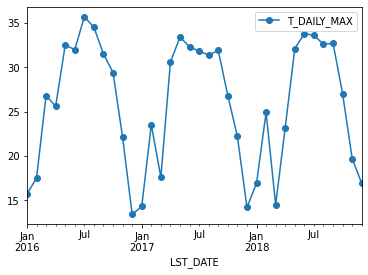

In [62]:
df.resample('M').max().plot(y='T_DAILY_MAX', marker='o')

### Rolling Operations

The final category of operations applies to "rolling windows". (See [rolling](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html) documentation.) We specify a function to apply over a moving window along the index. We specify the size of the window and, optionally, the weights. We also use the keyword `centered` to tell pandas whether to center the operation around the midpoint of the window.

<AxesSubplot:xlabel='LST_DATE'>

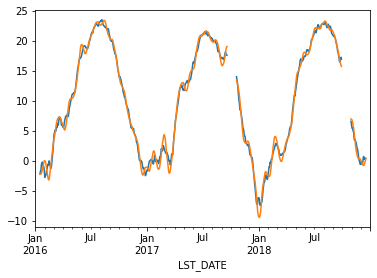

In [63]:
df.rolling(30, center=True).T_DAILY_MEAN.mean().plot()
df.rolling(30, center=True, win_type='triang').T_DAILY_MEAN.mean().plot()